In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
from pyspark.sql import SparkSession
from pyspark.sql.functions import year, col
import os



In [8]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import year, col, to_date, count, avg
import os

spark = SparkSession.builder.appName("US_Accidents_Preprocessing").getOrCreate()

file_path = "US_Accidents_March23.csv"
df = spark.read.option("header", True).option("inferSchema", True).csv(file_path)

print(f"Columnas iniciales: {df.columns}")

# Columnas que queremos para conteo y clima
required_cols = [
    "Start_Time", "Severity", "State", "City",
    "Weather_Condition", "Zipcode", "Timezone", "Weather_Timestamp",
    "Temperature(F)", "Wind_Chill(F)", "Humidity(%)", "Pressure(in)", 
    "Visibility(mi)", "Wind_Direction", "Wind_Speed(mph)", "Precipitation(in)"
]

# Filtramos para tener solo filas con datos no nulos en las columnas críticas para conteo y clima
df_clean = df.dropna(subset=[
    "Temperature(F)", "Wind_Chill(F)", "Humidity(%)", "Pressure(in)", 
    "Visibility(mi)", "Wind_Speed(mph)", "Precipitation(in)"
])

# Creamos columna de fecha para agrupar
df_clean = df_clean.withColumn("Date", to_date(col("Start_Time")))

# Extraemos el año
df_clean = df_clean.withColumn("Year", year(col("Date")))

# Filtramos años que queremos (2016 a 2023)
df_clean = df_clean.filter((col("Year") >= 2016) & (col("Year") <= 2023))

# Para el conteo diario por ciudad y estado
df_counts = df_clean.groupBy("Date", "City", "State", "Year") \
    .agg(count("*").alias("Daily_Accidents"))

# Para el promedio diario de variables climáticas, primero filtramos filas con datos de clima no nulos
climate_cols = [
    "Temperature(F)", "Wind_Chill(F)", "Humidity(%)", "Pressure(in)", 
    "Visibility(mi)", "Wind_Speed(mph)", "Precipitation(in)"
]

df_climate = df_clean.dropna(subset=climate_cols)

# Promediamos las variables climáticas por fecha, ciudad y estado
df_climate_avg = df_climate.groupBy("Date", "City", "State", "Year") \
    .agg(*[avg(col).alias(f"Avg_{col}") for col in climate_cols])

# Ahora juntamos conteo y clima en un solo df diario por ciudad y estado
df_daily = df_counts.join(df_climate_avg, on=["Date", "City", "State", "Year"], how="left")

output_dir = "/workspace/ADGE_project/datasets"
os.makedirs(output_dir, exist_ok=True)

# Guardar parquet por año
years = df_daily.select("Year").distinct().orderBy("Year").rdd.flatMap(lambda x: x).collect()

for yr in years:
    print(f"Guardando datos diarios del año {yr}...")
    df_year = df_daily.filter(col("Year") == yr)
    df_year.write.mode("overwrite").parquet(f"{output_dir}/daily_accidents_{yr}.parquet")

# Guardar resumen anual con promedio de accidentes diarios y promedio de clima
df_summary = df_daily.groupBy("Year").agg(
    avg("Daily_Accidents").alias("Avg_Daily_Accidents"),
    *[avg(f"Avg_{col}").alias(f"Avg_{col}") for col in climate_cols]
)

df_summary.coalesce(1).write.mode("overwrite").option("header", True) \
    .csv(f"{output_dir}/accidents_climate_summary.csv")

print("Preprocesado completo, compae. Todo ready pa los modelos.")


Columnas iniciales: ['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']


Guardando datos diarios del año 2016...


Guardando datos diarios del año 2017...


Guardando datos diarios del año 2018...


Guardando datos diarios del año 2019...


25/06/03 01:12:39 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/06/03 01:12:39 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 84.44% for 9 writers
25/06/03 01:12:39 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 76.00% for 10 writers
25/06/03 01:12:39 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 69.09% for 11 writers
25/06/03 01:12:39 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 63.33% for 12 writers
25/06/03 01:12:39 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 58.46% for 13 writers
25/06/03 01:12:39 WARN MemoryManager: Total allocation exceeds 95.

Guardando datos diarios del año 2020...


25/06/03 01:12:42 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/06/03 01:12:42 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 84.44% for 9 writers
25/06/03 01:12:42 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 76.00% for 10 writers
25/06/03 01:12:42 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 69.09% for 11 writers
25/06/03 01:12:42 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 63.33% for 12 writers
25/06/03 01:12:42 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 58.46% for 13 writers
25/06/03 01:12:42 WARN MemoryManager: Total allocation exceeds 95.

Guardando datos diarios del año 2021...


25/06/03 01:12:46 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/06/03 01:12:46 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 84.44% for 9 writers
25/06/03 01:12:46 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 76.00% for 10 writers
25/06/03 01:12:46 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 69.09% for 11 writers
25/06/03 01:12:46 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 63.33% for 12 writers
25/06/03 01:12:46 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 58.46% for 13 writers
25/06/03 01:12:46 WARN MemoryManager: Total allocation exceeds 95.

Guardando datos diarios del año 2022...


25/06/03 01:12:50 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/06/03 01:12:50 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 84.44% for 9 writers
25/06/03 01:12:50 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 76.00% for 10 writers
25/06/03 01:12:50 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 84.44% for 9 writers
25/06/03 01:12:50 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 76.00% for 10 writers
25/06/03 01:12:50 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 69.09% for 11 writers
25/06/03 01:12:50 WARN MemoryManager: Total allocation exceeds 95.0

Guardando datos diarios del año 2023...


Preprocesado completo, compae. Todo ready pa los modelos.


In [3]:
# Función para agrupar accidentes por fecha
def get_daily_accidents(df):
    df['Start_Time'] = pd.to_datetime(df['Start_Time'])
    df['date'] = df['Start_Time'].dt.date
    return df.groupby('date').size().reset_index(name='accident_count')

# Ruta donde están guardados los .parquet por año
data_dir = "datasets"  # ajusta si lo guardaste en otra ruta

# Cargar todos los datasets .parquet
data_by_year = {}
for file in glob(f"{data_dir}/accidents_*.parquet"):
    year = int(os.path.basename(file).split("_")[1].split(".")[0])
    df = pd.read_parquet(file)
    data_by_year[year] = df
    print(f"Año {year}: {df.shape[0]} accidentes cargados")


Año 2022: 1723701 accidentes cargados
Año 2018: 871896 accidentes cargados
Año 2019: 936059 accidentes cargados
Año 2023: 240002 accidentes cargados
Año 2017: 700517 accidentes cargados
Año 2021: 1531387 accidentes cargados
Año 2020: 1148892 accidentes cargados
Año 2016: 402239 accidentes cargados


In [4]:
daily_by_year = {year: get_daily_accidents(df) for year, df in data_by_year.items()}


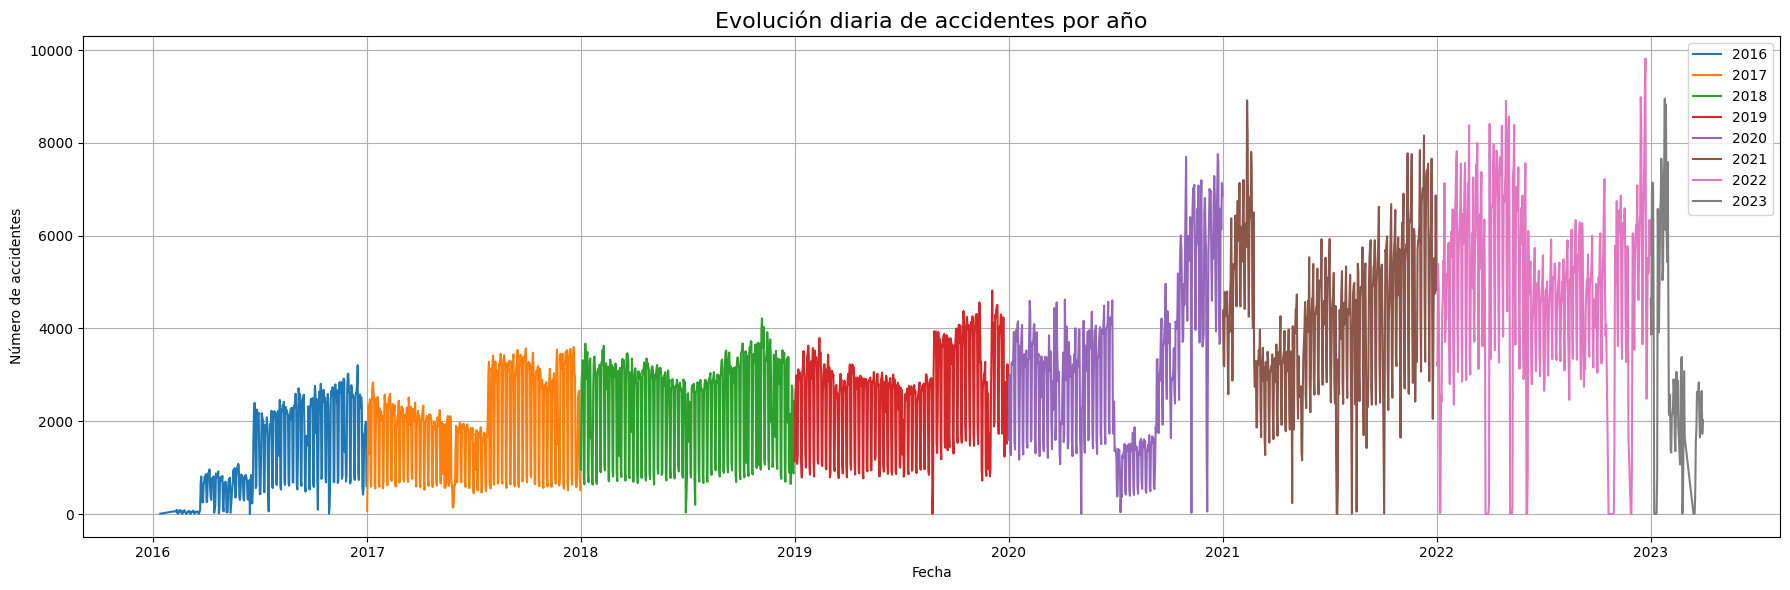

In [5]:
plt.figure(figsize=(18, 6))
for year, df in sorted(daily_by_year.items()):
    plt.plot(df['date'], df['accident_count'], label=f'{year}')

plt.title("Evolución diaria de accidentes por año", fontsize=16)
plt.xlabel("Fecha")
plt.ylabel("Número de accidentes")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



🔎 Correlación entre accidentes y variables climáticas en 2021:

Humidity(%)          0.360303
Visibility(mi)      -0.372239
Temperature(F)      -0.244218
Precipitation(in)    0.098575
Name: accident_count, dtype: float64


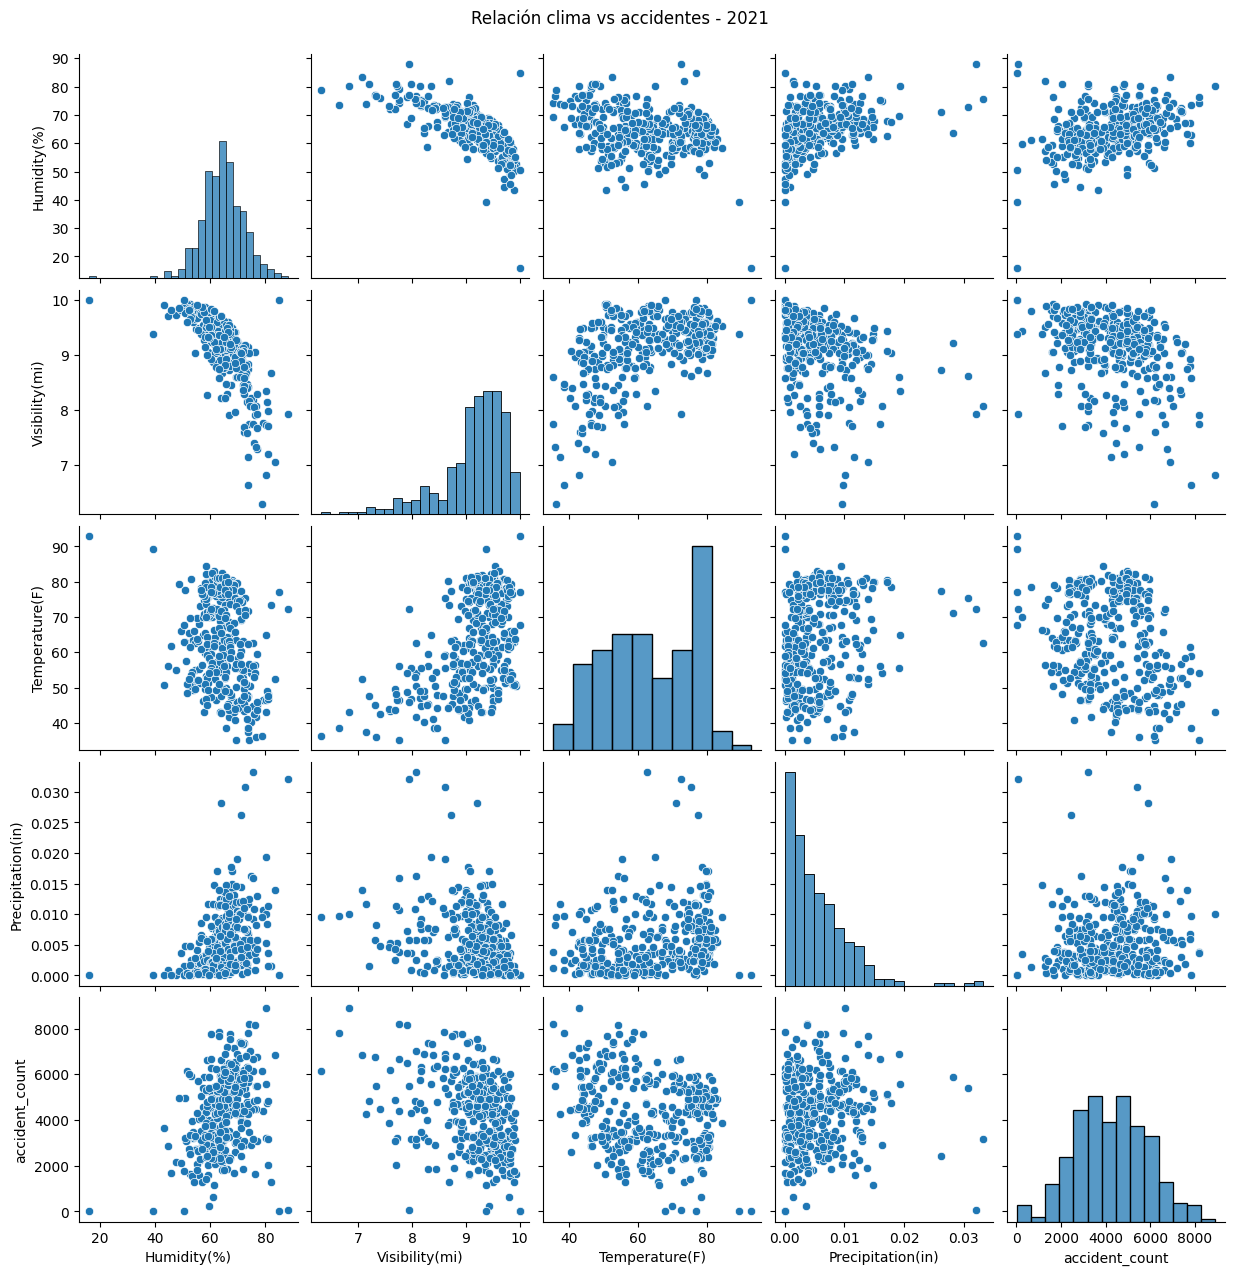

In [14]:
def climate_impact_analysis(df, year):
    df['Start_Time'] = pd.to_datetime(df['Start_Time'])
    df['date'] = df['Start_Time'].dt.date

    # Variables útiles
    clima_vars = ['Humidity(%)', 'Visibility(mi)', 'Temperature(F)', 'Precipitation(in)']

    df_clima = df[['date', *clima_vars]].dropna()
    df_clima_grouped = df_clima.groupby('date').mean().reset_index()

    df_accidents = df.groupby('date').size().reset_index(name='accident_count')

    df_merge = pd.merge(df_accidents, df_clima_grouped, on='date')
    
    # Correlación con clima
    corr = df_merge.corr(numeric_only=True)['accident_count'].drop('accident_count')
    print(f"\n🔎 Correlación entre accidentes y variables climáticas en {year}:\n")
    print(corr)

    # Visualizar relaciones
    sns.pairplot(df_merge, vars=clima_vars + ['accident_count'])
    plt.suptitle(f"Relación clima vs accidentes - {year}", y=1.02)
    plt.show()

# Elegimos un año para ejemplificar (puedes correr para cada uno)
climate_impact_analysis(data_by_year[2021], 2021)



Correlaciones por año:
      Humidity(%)  Visibility(mi)  Temperature(F)  Precipitation(in)
Year                                                                
2016     0.199623       -0.017178        0.232256           0.296371
2017     0.226769       -0.089865       -0.026579           0.067561
2018     0.102465       -0.045402       -0.041592           0.026088
2019     0.054540       -0.010423       -0.097921          -0.118407
2020     0.187451       -0.196219       -0.448123          -0.095907
2021     0.360303       -0.372239       -0.244218           0.098575
2022     0.115901       -0.183102       -0.024609           0.078928
2023     0.273114       -0.229244        0.084183           0.140018


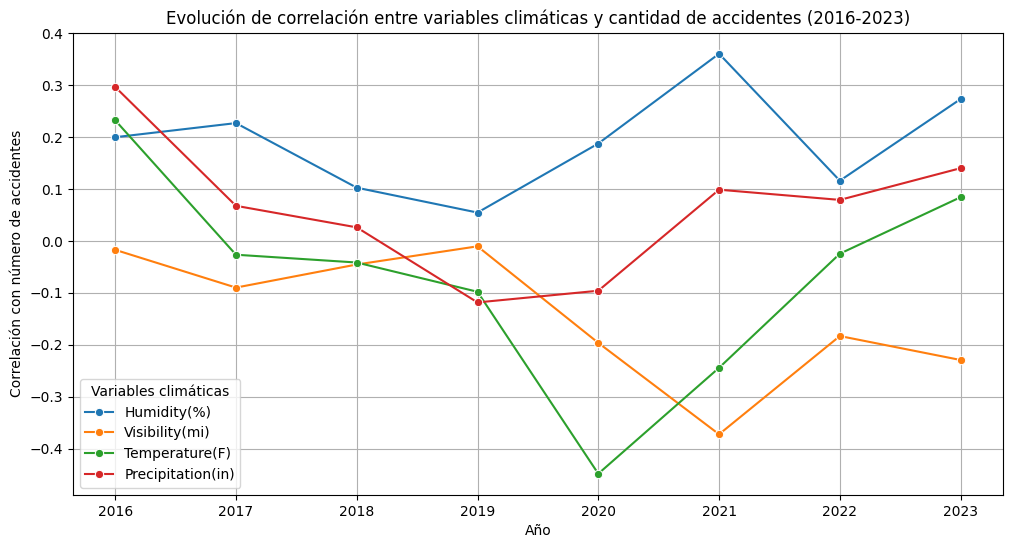

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def correlations_over_years(data_by_year, start_year=2016, end_year=2023):
    clima_vars = ['Humidity(%)', 'Visibility(mi)', 'Temperature(F)', 'Precipitation(in)']
    corr_list = []

    for year in range(start_year, end_year + 1):
        df = data_by_year.get(year)
        if df is None:
            print(f"Año {year} no disponible en data_by_year, se salta...")
            continue

        df['Start_Time'] = pd.to_datetime(df['Start_Time'])
        df['date'] = df['Start_Time'].dt.date

        df_clima = df[['date', *clima_vars]].dropna()
        df_clima_grouped = df_clima.groupby('date').mean().reset_index()

        df_accidents = df.groupby('date').size().reset_index(name='accident_count')

        df_merge = pd.merge(df_accidents, df_clima_grouped, on='date')

        corr = df_merge.corr(numeric_only=True)['accident_count'].drop('accident_count')
        corr_list.append(corr.to_dict())

    # Crear dataframe con años y correlaciones
    corr_df = pd.DataFrame(corr_list, index=range(start_year, start_year + len(corr_list)))
    corr_df.index.name = 'Year'
    return corr_df

# Ejecutamos la función
corr_df = correlations_over_years(data_by_year, 2016, 2023)

print("\nCorrelaciones por año:")
print(corr_df)

# Plotear la evolución de las correlaciones
plt.figure(figsize=(12,6))
for col in corr_df.columns:
    sns.lineplot(data=corr_df, x=corr_df.index, y=col, marker='o', label=col)

plt.title('Evolución de correlación entre variables climáticas y cantidad de accidentes (2016-2023)')
plt.xlabel('Año')
plt.ylabel('Correlación con número de accidentes')
plt.legend(title='Variables climáticas')
plt.grid(True)
plt.show()
